# TFP Probabilistic Layers: Variational Auto Encoder

In this example we show how to fit a Variational Autoencoder using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
#@title Import { display-mode: "form" }

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

### Load Dataset

In [3]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.AUTOTUNE))

2022-04-07 02:27:33.741715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 02:27:34.081617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 980 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


Note that _preprocess() above returns `image, image` rather than just `image` because Keras is set up for discriminative models with an (example, label) input format, i.e. $p_\theta(y|x)$. Since the goal of the VAE is to recover the input x from x itself (i.e. $p_\theta(x|x)$), the data pair is (example, example).

### VAE Code Golf

#### Specify model.

In [7]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [8]:
prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfp.layers.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),
])

2022-04-07 02:30:58.537327: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          200768    
                                                                 
 flatten (Flatten)           (None, 64)                0

In [7]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[encoded_size]),
    tf.keras.layers.Reshape([1, 1, encoded_size]),
    tf.keras.layers.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tf.keras.layers.Flatten(),
    tfp.layers.IndependentBernoulli(input_shape, tfp.distributions.Bernoulli.logits),
])

In [8]:
vae = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

#### Do inference.

In [9]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=15,
            validation_data=eval_dataset)

Epoch 1/15


2022-04-06 03:01:43.111085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-04-06 03:01:44.220034: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - 15s 28ms/step - loss: 205.6365 - val_loss: 157.2349
Epoch 2/15
235/235 [==============================] - 9s 22ms/step - loss: 147.5238 - val_loss: 139.3642
Epoch 3/15
235/235 [==============================] - 9s 22ms/step - loss: 136.8972 - val_loss: 132.6543
Epoch 4/15
235/235 [==============================] - 8s 21ms/step - loss: 131.6752 - val_loss: 129.7989
Epoch 5/15
235/235 [==============================] - 8s 23ms/step - loss: 128.3256 - val_loss: 125.9242
Epoch 6/15
235/235 [==============================] - 9s 22ms/step - loss: 125.5745 - val_loss: 123.6129
Epoch 7/15
235/235 [==============================] - 8s 22ms/step - loss: 123.1469 - val_loss: 121.3018
Epoch 8/15
235/235 [==============================] - 9s 22ms/step - loss: 121.6723 - val_loss: 120.4660
Epoch 9/15
235/235 [==============================] - 8s 22ms/step - loss: 120.5442 - val_loss: 119.5261
Epoch 10/15
235/235 [==============================] - 8s 22ms/st

### Look Ma, No ~~Hands~~Tensors!

In [10]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfp.distributions.Distribution)

In [11]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Originals:


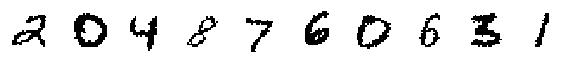

Decoded Random Samples:


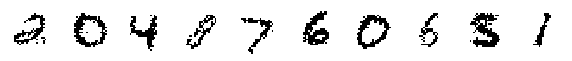

Decoded Modes:


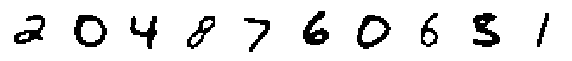

Decoded Means:


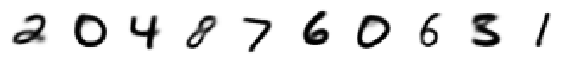

Decoded variance:


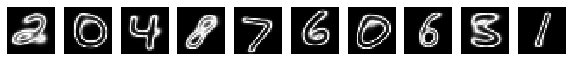

In [12]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

print('Decoded variance:')
display_imgs(xhat.variance())

In [13]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfp.distributions.Distribution)

Randomly Generated Samples:


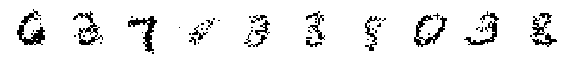

Randomly Generated Modes:


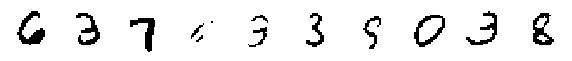

Randomly Generated Means:


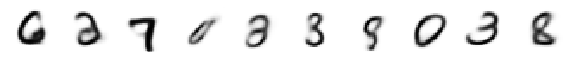

Randomly Generated variance:


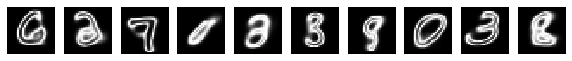

In [14]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

print('Randomly Generated variance:')
display_imgs(xtilde.variance())